Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

In [6]:
# Loading a CSV file into a DataFrame
df = pd.read_csv('../Processed dataset/image_statistics.csv')

# Dimension 
df.shape

(1794, 13)

In [7]:
# Display the first k rows of a DataFrame
df.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789
1,img01.bmp,top_left,void,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940
2,img01.bmp,top_left,void,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998
3,img01.bmp,top_left,void,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444
4,img01.bmp,top_left,void,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757
5,img01.bmp,top_left,void,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634
6,img01.bmp,top_left,void,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635
7,img01.bmp,top_left,void,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248
8,img01.bmp,top_left,void,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867
9,img01.bmp,top_left,void,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282


In [36]:
# Generate summary statistics for the dataframe 'df'
df.describe()

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000
mean,21.978818,1121.736901,157.754262,0.810496,0.104399,0.911231,0.552224,31.534230,18.943464,21.709660
std,13.040740,5670.111640,599.076427,0.199124,0.993198,0.051993,0.111112,38.249285,39.327878,30.942924
min,0.000000,1.000000,0.000000,0.000000,-1.571000,0.636000,0.125000,0.000000,0.000000,1.128000
25%,11.000000,126.250000,50.644750,0.765250,-0.999250,0.894000,0.500000,21.029500,8.052500,12.678500
50%,22.000000,280.500000,76.770000,0.881000,0.231500,0.927000,0.559000,26.724000,13.548000,18.898000
75%,33.000000,387.000000,85.386500,0.938000,0.937000,0.943000,0.607000,32.384750,19.502250,22.198000
max,47.000000,40223.000000,4388.970000,1.000000,1.571000,1.000000,1.000000,280.002000,278.184000,226.304000


For now on numeric variables only

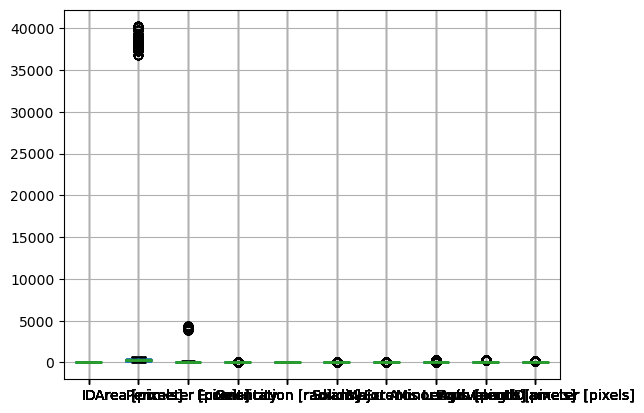

In [47]:
# Boxplot 
#for col in df.select_dtypes(include=np.number).columns.tolist():
df.boxplot(column=df.select_dtypes(include=np.number).columns.tolist())
plt.show() 


In [30]:
#Normality assumption

for col in df.select_dtypes(include=np.number).columns.tolist():
  # Shapiro-Wilk test
  _, p_value_SW = stats.shapiro(df[col])
  print('p-value of the Shapiro-Wilk ', col, ' test: %.3f' % p_value_SW)

p-value of the Shapiro-Wilk  ID  test: 0.000
p-value of the Shapiro-Wilk  Area [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Perimeter [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Eccentricity  test: 0.000
p-value of the Shapiro-Wilk  Orientation [radians]  test: 0.000
p-value of the Shapiro-Wilk  Solidity  test: 0.000
p-value of the Shapiro-Wilk  Extent  test: 0.000
p-value of the Shapiro-Wilk  Major Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Minor Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Equivalent Diameter [pixels]  test: 0.000


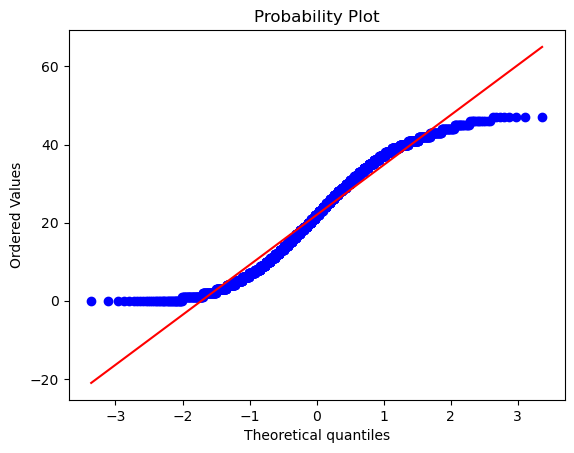

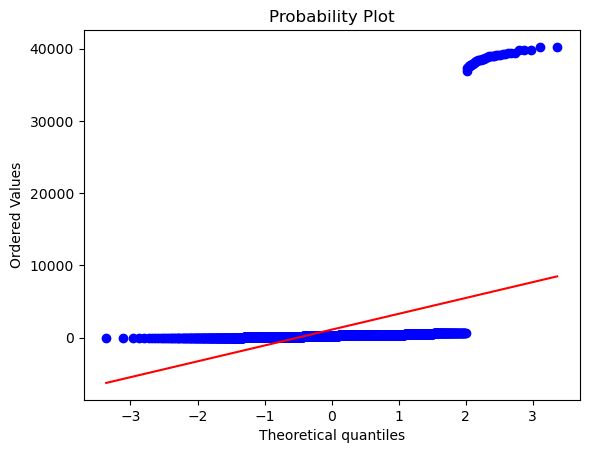

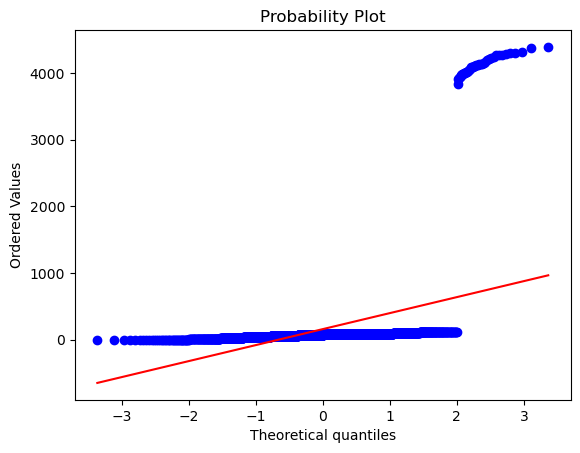

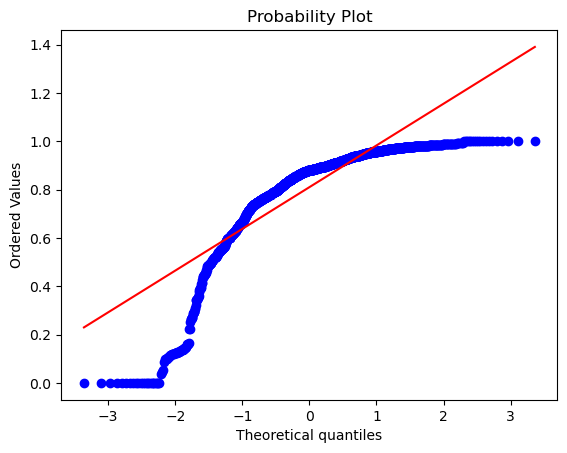

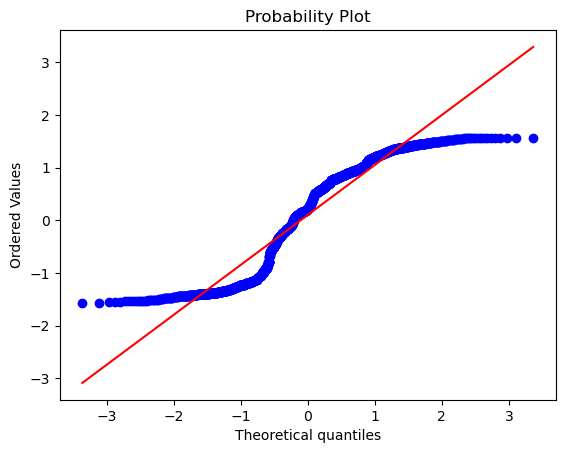

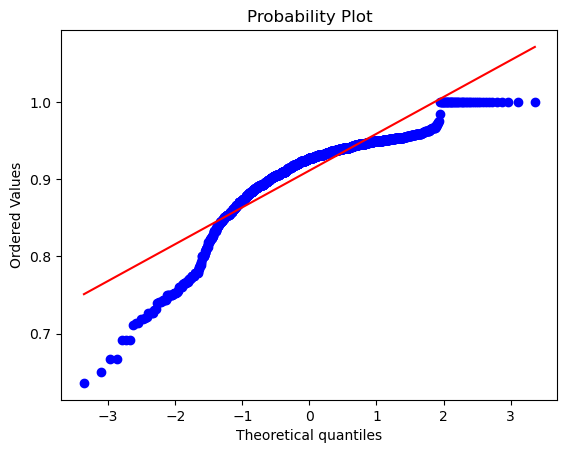

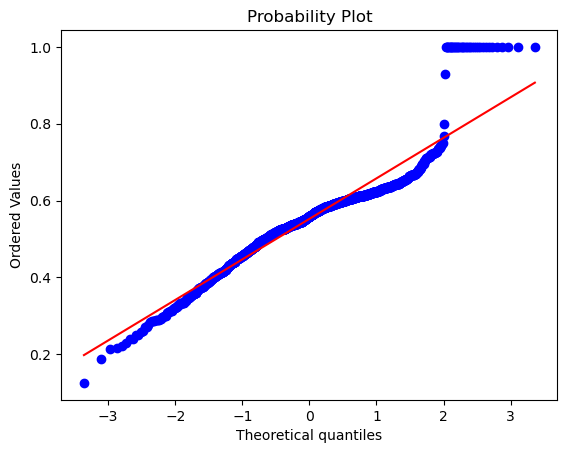

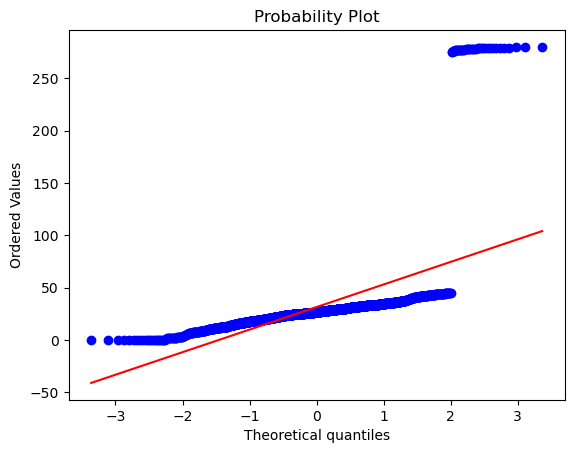

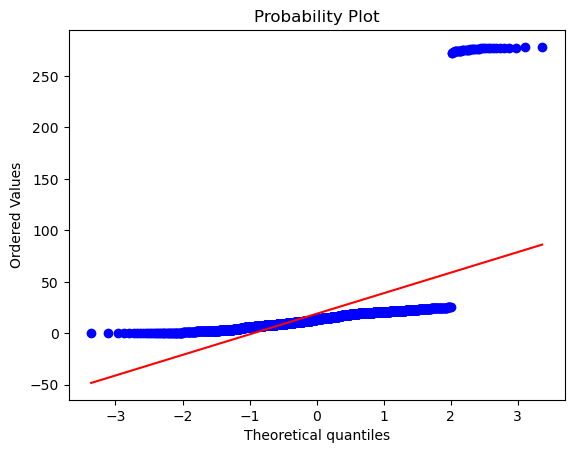

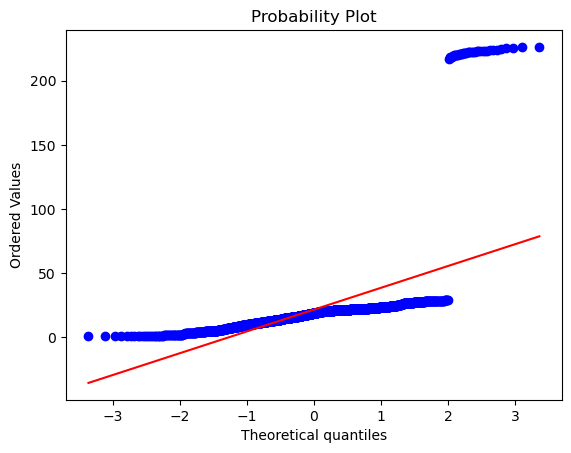

In [31]:
# QQ-plot
for col in df.select_dtypes(include=np.number).columns.tolist():
  stats.probplot(df[col], dist='norm', plot=plt)
  plt.show()